we have:

    at q state
    po q state
    po m div
    po q div
    at q zip3
    at y zip3
    at y tract
    
at y state -> at y county -> at y tract    

or 

at y state -> at y zip3 -> at y zip5  

a zip code may be shared by two couties. a tract may have multiple zips.


po m div -> po q state -> at y state -> at y county -> at y tract

or 

po m div -> po q state -> at y state -> at y zip3 -> at y zip5



# state_monthly

In [1]:
%reset -f

In [2]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [3]:
def read_po_monthly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_monthly_hist.csv", parse_dates=['Month'])
    #df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    cols=[u for u in df.columns if 'NSA' in u] +['Month']
    df=df[cols]
    cols=[u.split('(')[0].strip() for u in df.columns]
    df.columns=cols
    df=df[['Month','Middle Atlantic','East North Central','West North Central', 'South Atlantic','Pacific']]
    df=df[df.Month>=pd.to_datetime('1991-1-1')]
    df=df.set_index('Month')
    df.columns=["MA",'ENC','WNC','SA','PAC']
    assert df.isnull().sum().sum()==0
    return df

In [4]:
div_po_monthly=read_po_monthly_hpi()

In [5]:
div_po_monthly.head()

MA     ENC     WNC      SA     PAC
Month                                             
1991-01-01  100.00  100.00  100.00  100.00  100.00
1991-02-01  100.03  100.99  100.61  100.52  100.22
1991-03-01   99.92  101.34  100.41  100.97  100.02
1991-04-01   99.32  101.76  100.91  100.98  100.18
1991-05-01   99.58  102.38  100.73  100.82  100.40

In [6]:
div_po_monthly.index.max()

Timestamp('2017-12-01 00:00:00')

In [11]:
def read_po_state_quarterly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_state.txt" ,sep="\t")
    df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    df['hpi']=df['index_nsa'].astype(np.float)
    df=df[df.yr>1990]
    df['Month']=pd.to_datetime(df.apply(lambda u: '{}-{}-{}'.format(u['yr'], (u['qtr']-1)*3+2,1),axis=1))
    df=df.drop(['index_nsa','index_sa','Warning'],axis=1)
    assert df.isnull().sum().sum()==0
    df=pd.pivot_table(df, columns='state',values='hpi', index=['Month'])
    df=df[["NY", "OH", "IA", "NC", "CA"]]
    return df

In [12]:
state_po_quarterly=read_po_state_quarterly_hpi()

In [13]:
state_po_quarterly.index.max()

Timestamp('2017-11-01 00:00:00')

In [18]:
state_po_quarterly.head()

state           NY      OH      IA      NC      CA
Month                                             
1991-02-01  100.00  100.00  100.00  100.00  100.00
1991-05-01   99.52  101.50  101.27  100.48   99.68
1991-08-01  100.09  101.94  102.55  100.17   99.54
1991-11-01  100.37  102.87  103.17  101.73   99.68
1992-02-01  101.00  104.25  103.79  102.06   99.04

In [15]:
src=div_po_monthly.sort_index()
target=state_po_quarterly.sort_index()

In [26]:
dest=target[target.index>=pd.to_datetime('1991-1-1')]
dest=dest.reindex(src.index)
dest=dest.fillna(method='ffill').fillna(method='bfill')

In [31]:
assert dest.shape[0]==3*target.shape[0]

In [28]:
col_map={'CA': 'PAC', 'IA': 'WNC', 'NC': 'SA', 'NY': 'MA', 'OH': 'ENC'}

In [21]:
from dateutil.relativedelta import relativedelta

In [22]:
def make_quarter(dt):
    assert dt.month in {2,5,8,11}
    return [dt - relativedelta(months=1),dt,dt + relativedelta(months=1)]

In [23]:
def make_src_ratio(src,dt):
    quarter_dts1=make_quarter(dt)
    quarter_dts2=make_quarter(dt-relativedelta(months=3))
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [24]:
make_quarter(target.index[0])

[Timestamp('1991-01-01 00:00:00'),
 Timestamp('1991-02-01 00:00:00'),
 Timestamp('1991-03-01 00:00:00')]

In [25]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        quarter_dts=make_quarter(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [26]:
dest=[]
for col in target.columns:
    target_s=target[col]
    src_s=src[col_map[col]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns,index=src.index)

NY MA


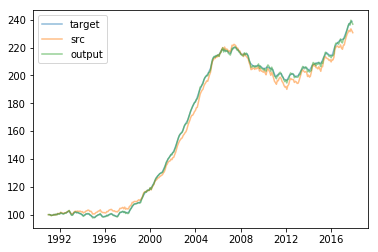

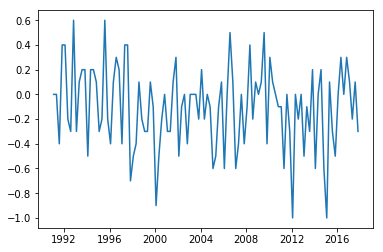

OH ENC


IA WNC


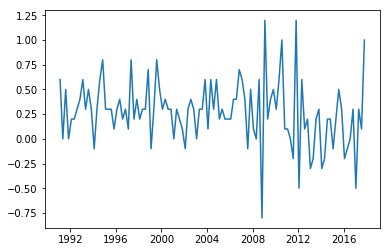

NC SA


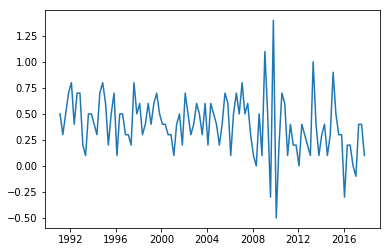

CA PAC


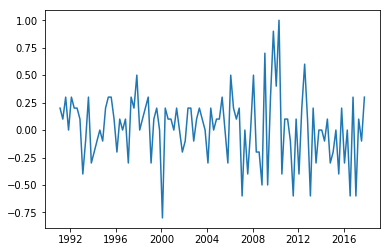

In [27]:
for i in range(len(dest.columns)):
    print dest.columns[i], src.columns[i]
    plt.plot(target.iloc[:,i],alpha=0.5)
    plt.plot(src.iloc[:,i],alpha=0.5)
    plt.plot(dest.iloc[:,i],alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(dest.iloc[:,i]/target.iloc[:,i]-1),1).dropna())
    plt.show()

In [28]:
dest.head()

state               NY          OH          IA          NC          CA
Month                                                                 
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000
1991-02-01  100.030000  100.990000  100.610000  100.520000  100.220000
1991-03-01   99.920000  101.340000  100.410000  100.970000  100.020000
1991-04-01   99.303394  101.734251  101.482901  100.898158   99.594000
1991-05-01   99.563350  102.354094  101.301879  100.738287   99.812714

In [153]:
dest.to_csv("../input/third2/HPI_po_state_monthly.csv")

# county monthly

In [188]:
%reset -f

In [189]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [190]:
state_po_monthly=pd.read_csv("../input/third2/HPI_po_state_monthly.csv", parse_dates=['Month']).set_index('Month')
print state_po_monthly.columns
state_po_monthly.columns=['36','39','19','37','06']

Index([u'NY', u'OH', u'IA', u'NC', u'CA'], dtype='object')


In [191]:
state_po_monthly.head()

36          39          19          37          06
Month                                                                 
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000
1991-02-01  100.030000  100.990000  100.610000  100.520000  100.220000
1991-03-01   99.920000  101.340000  100.410000  100.970000  100.020000
1991-04-01   99.303394  101.734251  101.482901  100.898158   99.594000
1991-05-01   99.563350  102.354094  101.301879  100.738287   99.812714

In [192]:
state_po_monthly.index.max()

Timestamp('2017-12-01 00:00:00')

In [212]:
county_at_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_county_5state.csv", dtype={'FIPS code':np.str}).set_index("FIPS code").T
county_at_hpi.index=pd.to_datetime(['{}-07-01'.format(u) for u in county_at_hpi.index])

In [213]:
county_at_hpi.index.max()

Timestamp('2017-07-01 00:00:00')

In [214]:
county_at_hpi.head()

FIPS code    06001       06003   06005   06007   06009   06011   06013  \
1991-07-01  488.25  102.504000  174.23  333.45  171.15  141.42  455.42   
1992-07-01  484.77  100.750770  178.42  335.84  172.09  150.06  450.27   
1993-07-01  473.42   95.534840  174.32  334.45  171.00  152.01  437.44   
1994-07-01  464.96   92.617165  172.16  336.09  167.30  149.31  428.41   
1995-07-01  459.56   90.207280  171.21  336.63  164.59  156.79  419.05   

FIPS code    06015   06017   06019   ...     39157   39159   39161      39163  \
1991-07-01  190.53  382.22  311.87   ...    171.83  216.27  118.86  76.453220   
1992-07-01  198.86  377.72  322.34   ...    174.94  222.96  121.91  78.806200   
1993-07-01  203.12  368.17  321.99   ...    182.47  230.81  125.39  81.244064   
1994-07-01  201.98  364.32  315.97   ...    197.84  242.46  130.94  84.551140   
1995-07-01  204.17  361.87  311.99   ...    210.05  266.49  135.56  88.941340   

FIPS code    39165   39167   39169   39171   39173   39175  
1991-07-01  218.00  122.27  196.34  123.66  175.54  117.79  
1992-07-01  223.91  123.97  201.27  126.15  180.86  120.43  
1993-07-01  230.99  130.88  208.43  125.67  184.13  125.26  
1994-07-01  241.54  141.00  225.73  134.61  192.03  125.71  
1995-07-01  251.15  152.13  243.07  149.77  203.72  135.74  

[5 rows x 402 columns]

In [215]:
src=state_po_monthly.sort_index()
target=county_at_hpi.sort_index()

In [197]:
from dateutil.relativedelta import relativedelta

In [221]:
def make_year(yr):
    return pd.to_datetime(['{}-{}-01'.format(yr,m) for m in range(1,13)])

In [222]:
def make_src_ratio(src,yr):
    quarter_dts1=make_year(yr)
    quarter_dts2=make_year(yr-1)
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [225]:
make_year(target.index[0].year)

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01', '1991-11-01', '1991-12-01'],
              dtype='datetime64[ns]', freq=None)

In [226]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        dt=dt.year
        quarter_dts=make_year(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [234]:
len(target.columns)

402

In [243]:
dest=[]
for col in target.columns[:]:
    target_s=target[col]
    src_s=src[col[:2]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns[:len(dest)],index=src.index)

255 37079


264 37099


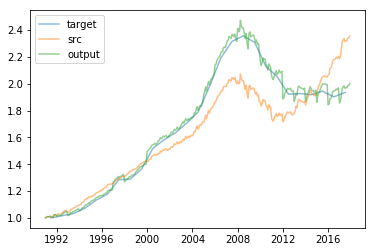

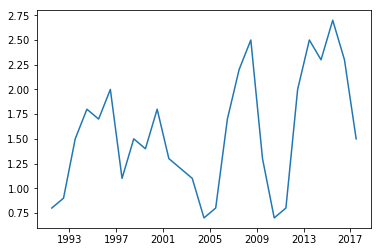

179 36051


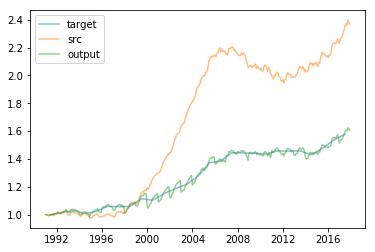

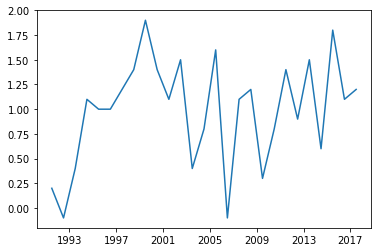

27 06055


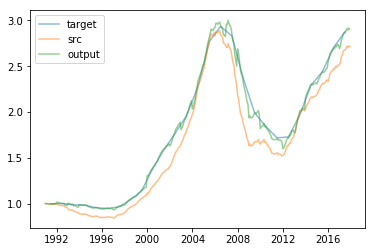

390 39153


137 19163


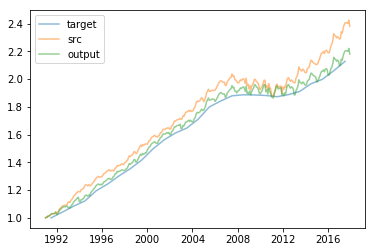

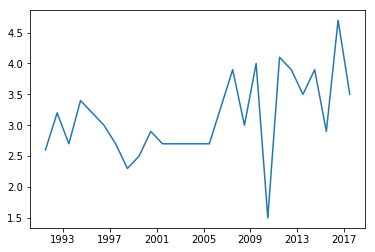

361 39095


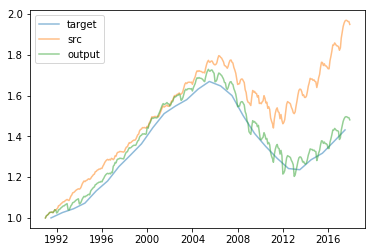

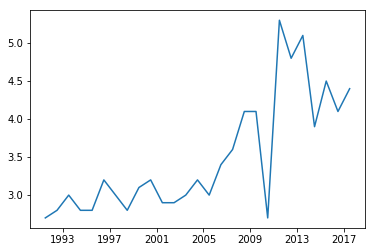

57 19003


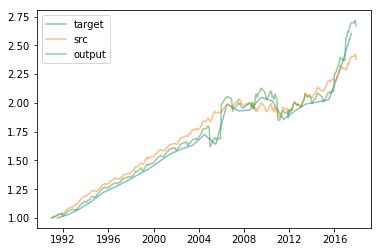

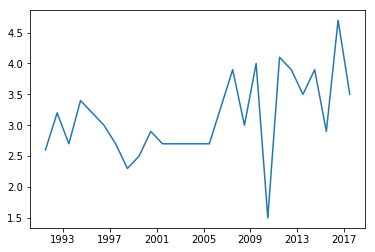

168 36029


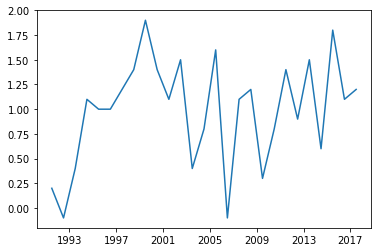

334 39041


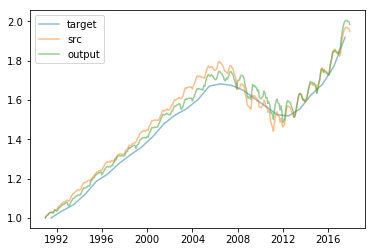

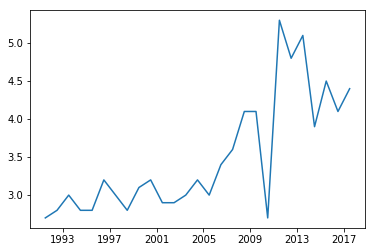

In [246]:
f=lambda u:u/u[0]
for i in np.random.choice(range(len(dest.columns)),10):
    print i, dest.columns[i] 
    plt.plot(f(target.iloc[:,i]),alpha=0.5)
    plt.plot(f(src.loc[:,dest.columns[i][:2]]),alpha=0.5)
    plt.plot(f(dest.iloc[:,i]),alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(f(dest.iloc[:,i])/f(target.iloc[:,i])-1),1).dropna())
    plt.show()

In [247]:
dest.head()

FIPS code        06001       06003       06005       06007       06009  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.220000  100.220000  100.220000  100.220000  100.220000   
1991-03-01  100.020000  100.020000  100.020000  100.020000  100.020000   
1991-04-01   99.594000   99.594000   99.594000   99.594000   99.594000   
1991-05-01   99.812714   99.812714   99.812714   99.812714   99.812714   

FIPS code        06011       06013       06015       06017       06019  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.220000  100.220000  100.220000  100.220000  100.220000   
1991-03-01  100.020000  100.020000  100.020000  100.020000  100.020000   
1991-04-01   99.594000   99.594000   99.594000   99.594000   99.594000   
1991-05-01   99.812714   99.812714   99.812714   99.812714   99.812714   

FIPS code      ...           39157       39159       39161       39163  \
Month          ...                                                       
1991-01-01     ...      100.000000  100.000000  100.000000  100.000000   
1991-02-01     ...      100.990000  100.990000  100.990000  100.990000   
1991-03-01     ...      101.340000  101.340000  101.340000  101.340000   
1991-04-01     ...      101.734251  101.734251  101.734251  101.734251   
1991-05-01     ...      102.354094  102.354094  102.354094  102.354094   

FIPS code        39165       39167       39169       39171       39173  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.990000  100.990000  100.990000  100.990000  100.990000   
1991-03-01  101.340000  101.340000  101.340000  101.340000  101.340000   
1991-04-01  101.734251  101.734251  101.734251  101.734251  101.734251   
1991-05-01  102.354094  102.354094  102.354094  102.354094  102.354094   

FIPS code        39175  
Month                   
1991-01-01  100.000000  
1991-02-01  100.990000  
1991-03-01  101.340000  
1991-04-01  101.734251  
1991-05-01  102.354094  

[5 rows x 402 columns]

In [248]:
dest.to_csv("../input/third2/HPI_at_county_monthly.csv")

# tract monthly

In [1]:
%reset -f

In [2]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [5]:
county_at_monthly=pd.read_csv("../input/third2/HPI_at_county_monthly.csv", parse_dates=['Month']).set_index('Month')
#state_po_monthly.columns=['36','39','19','37','06']

In [7]:
county_at_monthly.head()

06001       06003       06005       06007       06009  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.220000  100.220000  100.220000  100.220000  100.220000   
1991-03-01  100.020000  100.020000  100.020000  100.020000  100.020000   
1991-04-01   99.594000   99.594000   99.594000   99.594000   99.594000   
1991-05-01   99.812714   99.812714   99.812714   99.812714   99.812714   

                 06011       06013       06015       06017       06019  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.220000  100.220000  100.220000  100.220000  100.220000   
1991-03-01  100.020000  100.020000  100.020000  100.020000  100.020000   
1991-04-01   99.594000   99.594000   99.594000   99.594000   99.594000   
1991-05-01   99.812714   99.812714   99.812714   99.812714   99.812714   

               ...           39157       39159       39161       39163  \
Month          ...                                                       
1991-01-01     ...      100.000000  100.000000  100.000000  100.000000   
1991-02-01     ...      100.990000  100.990000  100.990000  100.990000   
1991-03-01     ...      101.340000  101.340000  101.340000  101.340000   
1991-04-01     ...      101.734251  101.734251  101.734251  101.734251   
1991-05-01     ...      102.354094  102.354094  102.354094  102.354094   

                 39165       39167       39169       39171       39173  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.990000  100.990000  100.990000  100.990000  100.990000   
1991-03-01  101.340000  101.340000  101.340000  101.340000  101.340000   
1991-04-01  101.734251  101.734251  101.734251  101.734251  101.734251   
1991-05-01  102.354094  102.354094  102.354094  102.354094  102.354094   

                 39175  
Month                   
1991-01-01  100.000000  
1991-02-01  100.990000  
1991-03-01  101.340000  
1991-04-01  101.734251  
1991-05-01  102.354094  

[5 rows x 402 columns]

In [8]:
assert county_at_monthly.isnull().sum().sum()==0

In [9]:
county_at_monthly.index.max()

Timestamp('2017-12-01 00:00:00')

In [12]:
tract_at_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_tract_5state.csv", dtype={'tract':np.str}).set_index("tract").T
tract_at_hpi.index=pd.to_datetime(['{}-07-01'.format(u) for u in tract_at_hpi.index])

In [14]:
tract_at_hpi.index.max()

Timestamp('2017-07-01 00:00:00')

In [15]:
tract_at_hpi.head()

tract       06001400100  06001400200  06001400300  06001400400  06001400500  \
1991-07-01       156.29       172.65       318.91       302.62       164.56   
1992-07-01       168.08       175.52       324.33       303.05       164.94   
1993-07-01       180.10       178.83       318.60       298.76       165.43   
1994-07-01       179.98       182.75       312.16       291.15       157.89   
1995-07-01       209.03       175.16       309.54       293.90       141.53   

tract       06001400600  06001400700  06001400800  06001400900  06001401000  \
1991-07-01       100.00       133.18    100.71787       100.00       100.00   
1992-07-01        94.42       137.74    100.00000        97.30        96.49   
1993-07-01        92.91       132.46    105.59000        88.21       105.05   
1994-07-01        87.21       144.79    106.47000        96.47        92.41   
1995-07-01        88.18       131.27    114.32000        98.35        89.97   

tract          ...       39173022200  39173022300  39173022400  39173022500  \
1991-07-01     ...           97.0585      97.0585      97.0585      97.0585   
1992-07-01     ...          100.0000     100.0000     100.0000     100.0000   
1993-07-01     ...          110.5800     101.5100      98.9000     101.5300   
1994-07-01     ...          115.2300     103.8800     101.1000     110.7300   
1995-07-01     ...          115.4400     121.4600     113.2600     113.7300   

tract       39175938000  39175938100  39175938200  39175938300  39175938400  \
1991-07-01    73.812515     97.80786    61.493088     97.80786     97.80786   
1992-07-01    75.466860    100.00000    62.871320    100.00000    100.00000   
1993-07-01    78.493550    106.06000    65.392850    107.24000    104.87000   
1994-07-01    78.775540    108.34000    65.627780    108.52000     98.85000   
1995-07-01    85.060790    112.45000    70.864006    120.72000    112.69000   

tract       39175938500  
1991-07-01    73.812515  
1992-07-01    75.466860  
1993-07-01    78.493550  
1994-07-01    78.775540  
1995-07-01    85.060790  

[5 rows x 14412 columns]

In [17]:
src=county_at_monthly.sort_index()
target=tract_at_hpi.sort_index()

In [18]:
from dateutil.relativedelta import relativedelta

In [19]:
def make_year(yr):
    return pd.to_datetime(['{}-{}-01'.format(yr,m) for m in range(1,13)])

In [20]:
def make_src_ratio(src,yr):
    quarter_dts1=make_year(yr)
    quarter_dts2=make_year(yr-1)
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [21]:
make_year(target.index[0].year)

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01', '1991-11-01', '1991-12-01'],
              dtype='datetime64[ns]', freq=None)

In [22]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        dt=dt.year
        quarter_dts=make_year(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [23]:
len(target.columns)

14412

In [25]:
%%time 
dest=[]
for i, col in enumerate(target.columns[:]):
    if i%1000==0: print i,
    target_s=target[col]
    src_s=src[col[:5]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns[:len(dest)],index=src.index)

 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000CPU times: user 7min 5s, sys: 620 ms, total: 7min 6s
Wall time: 7min 6s



4053 06065045122


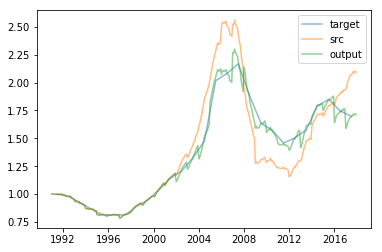

14276 39159050304


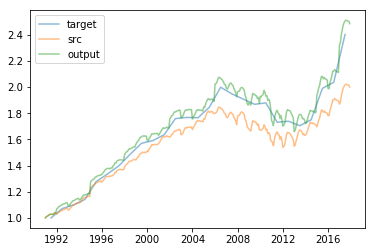

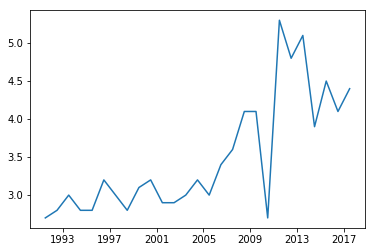

9737 36103158510


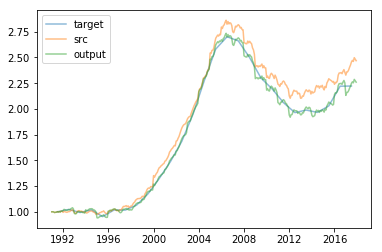

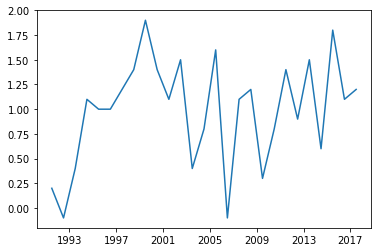

9777 36103159506


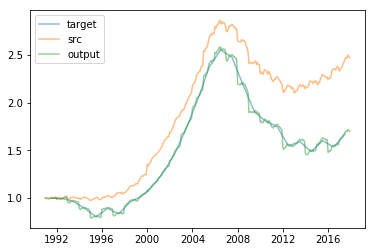

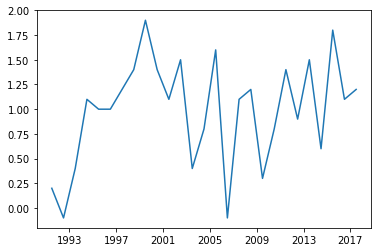

9666 36103146800


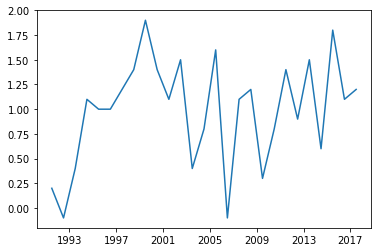

8403 36059303201


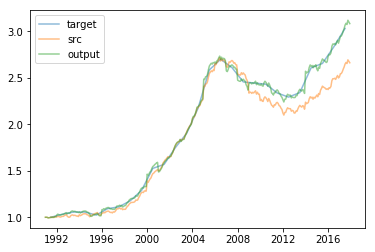

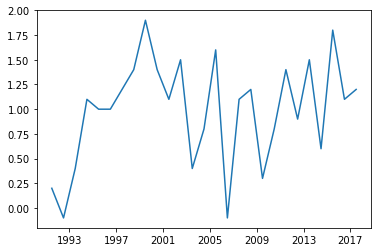

8205 36047099600


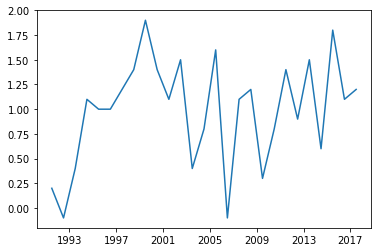

12351 39035136101


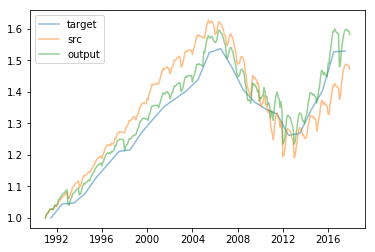

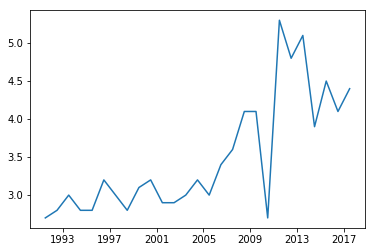

4355 06067009106


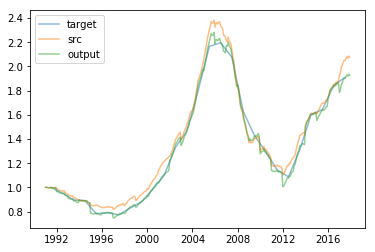

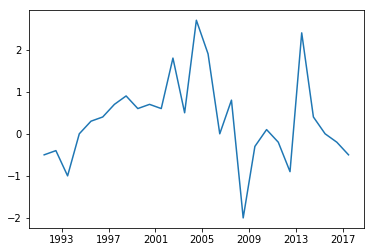

5981 06085505304


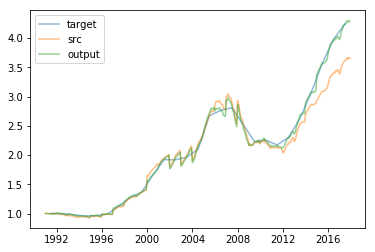

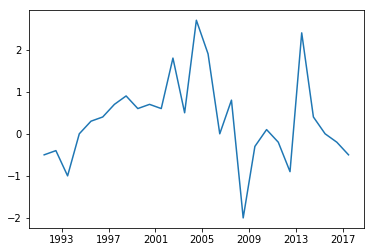

In [27]:
f=lambda u:u/u[0]
for i in np.random.choice(range(len(dest.columns)),10):
    print i, dest.columns[i] 
    plt.plot(f(target.iloc[:,i]),alpha=0.5)
    plt.plot(f(src.loc[:,dest.columns[i][:5]]),alpha=0.5)
    plt.plot(f(dest.iloc[:,i]),alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(f(dest.iloc[:,i])/f(target.iloc[:,i])-1),1).dropna())
    plt.show()

In [28]:
dest.head()

tract       06001400100  06001400200  06001400300  06001400400  06001400500  \
Month                                                                         
1991-01-01   100.000000   100.000000   100.000000   100.000000   100.000000   
1991-02-01   100.220000   100.220000   100.220000   100.220000   100.220000   
1991-03-01   100.020000   100.020000   100.020000   100.020000   100.020000   
1991-04-01    99.594000    99.594000    99.594000    99.594000    99.594000   
1991-05-01    99.812714    99.812714    99.812714    99.812714    99.812714   

tract       06001400600  06001400700  06001400800  06001400900  06001401000  \
Month                                                                         
1991-01-01   100.000000   100.000000   100.000000   100.000000   100.000000   
1991-02-01   100.220000   100.220000   100.220000   100.220000   100.220000   
1991-03-01   100.020000   100.020000   100.020000   100.020000   100.020000   
1991-04-01    99.594000    99.594000    99.594000    99.594000    99.594000   
1991-05-01    99.812714    99.812714    99.812714    99.812714    99.812714   

tract          ...       39173022200  39173022300  39173022400  39173022500  \
Month          ...                                                            
1991-01-01     ...        100.000000   100.000000   100.000000   100.000000   
1991-02-01     ...        100.990000   100.990000   100.990000   100.990000   
1991-03-01     ...        101.340000   101.340000   101.340000   101.340000   
1991-04-01     ...        101.734251   101.734251   101.734251   101.734251   
1991-05-01     ...        102.354094   102.354094   102.354094   102.354094   

tract       39175938000  39175938100  39175938200  39175938300  39175938400  \
Month                                                                         
1991-01-01   100.000000   100.000000   100.000000   100.000000   100.000000   
1991-02-01   100.990000   100.990000   100.990000   100.990000   100.990000   
1991-03-01   101.340000   101.340000   101.340000   101.340000   101.340000   
1991-04-01   101.734251   101.734251   101.734251   101.734251   101.734251   
1991-05-01   102.354094   102.354094   102.354094   102.354094   102.354094   

tract       39175938500  
Month                    
1991-01-01   100.000000  
1991-02-01   100.990000  
1991-03-01   101.340000  
1991-04-01   101.734251  
1991-05-01   102.354094  

[5 rows x 14412 columns]

In [29]:
dest.to_csv("../input/third2/HPI_at_tract_monthly.csv")